In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rc('pdf', fonttype=42) # Avoid type 3 fonts

sns.set_theme(style="white")
sns.set_palette(sns.color_palette("tab10"))
plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True}) # enables minor ticks

In [2]:
BASE_DIR = '../ios'
DATA_DIR = os.path.join(BASE_DIR, '../results/ios-2024-02-26')

FILES = [
  # '2024-02-26-174829_hidden_iPhone14-7_16-1.json',
  # '2024-02-26-174845_hidden_iPhone14-7_16-1.json',
  # '2024-02-26-174855_hidden_iPhone14-7_16-1.json',
  # '2024-02-26-174906_hidden_iPhone14-7_16-1.json',
  # '2024-02-26-174924_hidden_iPhone14-7_16-1.json',
  '2024-02-26-175253_hidden_iPhone12-1_16-3.json',
  '2024-02-26-175304_hidden_iPhone12-1_16-3.json',
  '2024-02-26-175319_hidden_iPhone12-1_16-3.json',
  '2024-02-26-175333_hidden_iPhone12-1_16-3.json',
  '2024-02-26-175358_hidden_iPhone12-1_16-3.json',
  '2024-02-26-175920_hidden_iPhone13-2_15-6-1.json',
  '2024-02-26-175931_hidden_iPhone13-2_15-6-1.json',
  '2024-02-26-175943_hidden_iPhone13-2_15-6-1.json',
  '2024-02-26-175956_hidden_iPhone13-2_15-6-1.json',
  '2024-02-26-180016_hidden_iPhone13-2_15-6-1.json',
  '2024-02-26-180358_hidden_iPhone14-5_16-0-2.json',
  '2024-02-26-180420_hidden_iPhone14-5_16-0-2.json',
  '2024-02-26-180435_hidden_iPhone14-5_16-0-2.json',
  '2024-02-26-180453_hidden_iPhone14-5_16-0-2.json',
  '2024-02-26-180514_hidden_iPhone14-5_16-0-2.json',
]


def get_device_info(device_name):
    with open(os.path.join(BASE_DIR, 'server/models.json')) as f:
        return json.load(f)[device_name]


def read_data(path):
    with open(path) as f:
        d = json.load(f)
        
    info = get_device_info(d['device'])
    
    return pd.DataFrame(data={
        'Device': info['name'],
        'OS Version': d['version'],
        'Chip': info['chip'],
        'Configuration': f"{info['name']} ({d['version']})",
        'maxSize': d['maxSize'],
        'Measurement': [float(x) * 1000 for x in d['executionTimeSeconds']],
    })


def read_all_data():
    for f in FILES:
        path = os.path.join(DATA_DIR, f)
        x = read_data(path)
        yield x
        
df = pd.concat(read_all_data())
df.sample(10)

,Device,OS Version,Chip,Configuration,maxSize,Measurement
6,iPhone 11,16.3,A13,iPhone 11 (16.3),3162277,277.326941
1,iPhone 11,16.3,A13,iPhone 11 (16.3),10000000,340.592980
9,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),3162277,573.423982
8,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),10000000,619.112015
5,iPhone 13,16.0.2,A15,iPhone 13 (16.0.2),3162277,572.237968
8,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),100000000,1016.726971
9,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),31622776,390.052080
7,iPhone 11,16.3,A13,iPhone 11 (16.3),31622776,606.187940
3,iPhone 12,15.6.1,A14,iPhone 12 (15.6.1),31622776,415.760994
1,iPhone 11,16.3,A13,iPhone 11 (16.3),31622776,544.772029


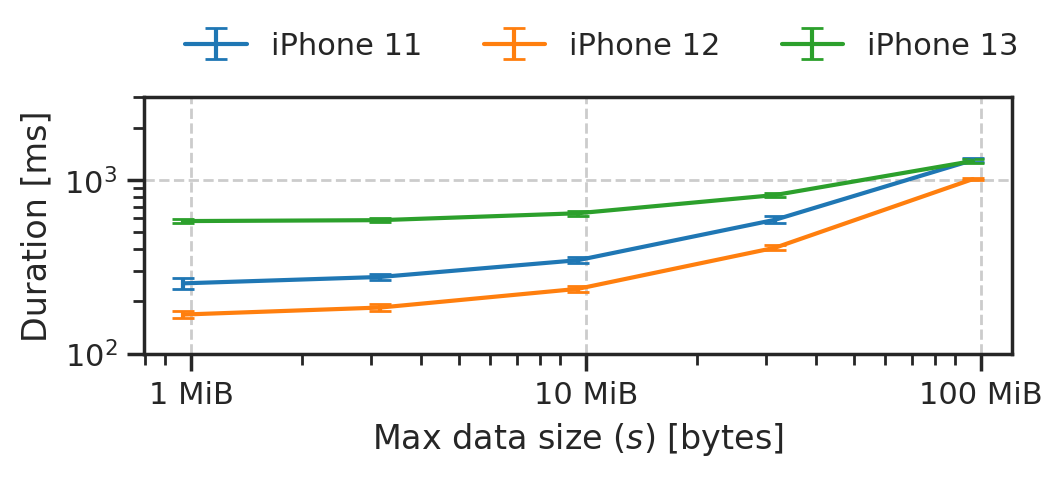

In [3]:
#
# Line plot with error bars for ratchet operation given payload size
#

MIB = 1024 * 1024

def draw_plot_for_test(df):
    fig, ax = plt.subplots()
    fig.set_size_inches((5.5, 2.2))
    
    def draw_plot_for_name(data, ax, name):
        grouped = data[data.Device==name][["maxSize", "Measurement"]].groupby("maxSize", as_index=False)

        means = grouped.mean()
        errors = grouped.std()

        handle = ax.errorbar(
            x=means["maxSize"], y=means["Measurement"], yerr=errors["Measurement"],
            fmt='', ls='-',
            ms=5, capsize=4)
        handle.set_label(name)

    for name in sorted(list(set(df['Device']))):
        draw_plot_for_name(df, ax, name)

    ax.set_xlabel("Max data size ($s$) [bytes]")
    ax.set_xscale("log")
    ax.set_xticks([1*MIB, 10*MIB, 100*MIB])
    ax.set_xticklabels(["1 MiB", "10 MiB", "100 MiB"])


    ax.set_ylabel("Duration [ms]")
    ax.set_yscale("log")
    ax.set_ylim((100, 3*1_000))

    ax.grid(ls='--')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(0.97, 1.13), frameon=False)

    fig.tight_layout()
    fig.savefig("output/ios-hidden-sloth-bench.pdf", bbox_inches='tight')

    
draw_plot_for_test(df)